In [1]:
import pandas as pd


number_rows = 200
name_cols = ["Content", "Label"]
data = pd.read_csv("../data/cleaned_hate_speech.csv", nrows=number_rows, usecols=name_cols)

data.head()

,Content,Label
0,denial normal con ask comment tragedy emotiona...,1
1,able tweet insufferable bullshit proves trump ...,1
2,retard cute single life,1
3,thought real badass mongol style declaration w...,1
4,afro american basho,1


In [2]:
class SingletonMeta(type):
    _instances = {}

    def __call__(cls, *args, **kwargs):
        if cls not in cls._instances:
            instance = super().__call__(*args, **kwargs)
            cls._instances[cls] = instance
        return cls._instances[cls]

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

class BertModel(metaclass=SingletonMeta):
    def __init__(self):
        print("Initializing the model...")
        self.tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
        self.model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')


c:\Users\gbiba\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class ModelFactory:
    @staticmethod
    def create_model(model_name):
        if model_name == "distilbert":
            return BertModel()
        elif model_name == "roberta":
            return AutoModelForSequenceClassification.from_pretrained('roberta-base')
        else:
            raise ValueError(f"Model '{model_name}' not recognized.")


In [5]:
# Sélection du modèle
model_bert = ModelFactory.create_model("distilbert")
# model_roberta = ModelFactory.create_model("roberta")


Initializing the model...


In [6]:
texts = data["Content"].dropna().tolist()
labels = data['Label'].dropna().tolist()


In [7]:
import time

# Décorateur pour mesurer le temps
def time_logger(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print("-"*50)
        print(f"===>  Execution time for {func.__name__}: {end_time - start_time:.4f} seconds")
        print("-"*50)
        return result
    return wrapper


In [8]:
def data_generator(dataframe, batch_size=8):
    for start in range(0, len(dataframe), batch_size):
        end = min(start + batch_size, len(dataframe))
        yield dataframe.iloc[start:end]


In [9]:
bertModel = BertModel()
tokenizer = bertModel.tokenizer


inputs = tokenizer(texts, padding=True, truncation=True, max_length=32, return_tensors="pt")

print(inputs)

{'input_ids': tensor([[  101, 14920,  3671,  ...,     0,     0,     0],
        [  101,  2583,  1056,  ...,     0,     0,     0],
        [  101,  2128,  7559,  ...,     0,     0,     0],
        ...,
        [  101,  1056, 24281,  ...,     0,     0,     0],
        [  101, 24869,  2015,  ...,     0,     0,     0],
        [  101,  2128,  7559,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [10]:
model = model_bert.model

@time_logger
def Inference():
    # Passer des textes au modèle
    outputs = model(**inputs)

    # Nous obtenons les Logits (valeurs brutes)
    logits = outputs.logits
    return logits

logits = Inference()
print(logits)

--------------------------------------------------
===>  Execution time for Inference: 6.5854 seconds
--------------------------------------------------
tensor([[ 3.5946, -2.9560],
        [ 2.9963, -2.4716],
        [-1.3527,  1.3906],
        [ 1.1218, -0.9328],
        [ 1.8733, -1.6835],
        [ 2.6645, -2.2684],
        [ 1.0904, -0.7945],
        [ 3.4231, -2.8890],
        [ 1.9892, -1.7098],
        [ 3.0174, -2.5275],
        [ 4.2766, -3.5325],
        [ 3.0712, -2.5601],
        [ 4.1467, -3.3991],
        [ 3.0481, -2.5473],
        [ 3.9405, -3.2825],
        [ 2.8284, -2.3948],
        [-2.3860,  2.5382],
        [ 3.2670, -2.6940],
        [ 3.3147, -2.7403],
        [ 0.8868, -0.7981],
        [-0.4360,  0.4834],
        [ 3.0324, -2.5548],
        [ 0.6659, -0.6656],
        [ 3.5816, -3.0141],
        [ 4.0487, -3.3480],
        [-2.2526,  2.3199],
        [ 3.2883, -2.8379],
        [ 1.7861, -1.5886],
        [ 3.0874, -2.5672],
        [ 1.7341, -1.4487],
       

In [11]:
# Utilisez Softmax pour obtenir la probabilité de chaque catégorie.
import torch
probabilities = torch.nn.functional.softmax(logits, dim=1)

# Afficher les possibilités
for i, sentence in enumerate(texts):
    print(f"Comment: {sentence}")
    print(f"Positive: {probabilities[i][1].item():.4f}, Negative: {probabilities[i][0].item():.4f}")
    print("-" * 50)

Comment: denial normal con ask comment tragedy emotional retard
Positive: 0.0014, Negative: 0.9986
--------------------------------------------------
Comment: able tweet insufferable bullshit proves trump nazi vagina
Positive: 0.0042, Negative: 0.9958
--------------------------------------------------
Comment: retard cute single life
Positive: 0.9395, Negative: 0.0605
--------------------------------------------------
Comment: thought real badass mongol style declaration war attacker capture citizen soon
Positive: 0.1136, Negative: 0.8864
--------------------------------------------------
Comment: afro american basho
Positive: 0.0277, Negative: 0.9723
--------------------------------------------------
Comment: yeah retard haha
Positive: 0.0072, Negative: 0.9928
--------------------------------------------------
Comment: ching chong chung stuff
Positive: 0.1318, Negative: 0.8682
--------------------------------------------------
Comment: dead slut warm tweet slut vagina mate obama send 

In [12]:
from torch.utils.data import Dataset, DataLoader

class CommentDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.texts = dataframe['Content'].tolist()
        self.labels = dataframe['Label'].tolist()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=32, return_tensors="pt")
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), torch.tensor(self.labels[idx])

# Créer un chargeur de données
dataset = CommentDataset(data)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# # Configuration du modèle et optimiseur
# optimizer = optim.Adam(model.parameters(), lr=1e-5)
# criterion = nn.CrossEntropyLoss()

# # Training Loop
# for epoch in range(3):
#     print(f"Epoch {epoch+1}...")

#     for input_ids, attention_mask, labels in dataloader:
#         optimizer.zero_grad()
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
#         loss = criterion(outputs.logits, labels)
#         loss.backward()
#         optimizer.step()
    
#     print(f"Loss: {loss.item()}")


### **Mesures d'évaluation du modèle à l'aide de la `(Evaluation Metrics)`, de précision, de rappel et de confusion**

In [13]:
from torch.nn.functional import softmax

#1- Calcul des probabilités
probabilities = softmax(logits, dim=1)

# - Extract final predictions (0 or 1)
predictions = torch.argmax(probabilities, dim=1)

print("Predictions:", predictions)

Predictions: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1])


In [14]:
all_labels = labels

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Convert predictions and labels to CPU to avoid CUDA problems
all_labels = torch.tensor(all_labels[:len(predictions)]).cpu()
predictions = predictions.cpu()

# Scale calculation
accuracy = accuracy_score(all_labels, predictions)
precision = precision_score(all_labels, predictions, zero_division=0)
recall = recall_score(all_labels, predictions, zero_division=0)
f1 = f1_score(all_labels, predictions, zero_division=0)

# Show results
print(f"- Accuracy: {accuracy:.4f}")
print(f"- Precision: {precision:.4f}")
print(f"- Recall: {recall:.4f}")
print(f"- F1-Score: {f1:.4f}")

- Accuracy: 0.2050
- Precision: 1.0000
- Recall: 0.2050
- F1-Score: 0.3402


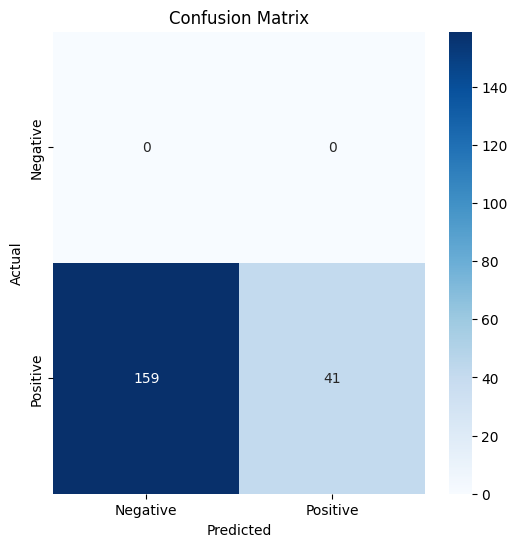

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the Confusion Matrix
cm = confusion_matrix(all_labels, predictions)

# Confusion Matrix drawing
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Negative", "Positive"], 
            yticklabels=["Negative", "Positive"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [17]:
def predict_sentiment(text):
    #  Tokenization
    inputs = tokenizer(text, padding=True, truncation=True, max_length=32, return_tensors="pt")
    
    # Passeur pour le modèle
    with torch.no_grad():
        outputs = model(**inputs)
    
    #Extraire les prévisions
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).item()
    
    # Attribuer des catégories
    label = "Positive" if predictions == 1 else "Negative"
    score = torch.softmax(logits, dim=1).max().item()
    
    return {"label": label, "confidence": round(score, 4)}


In [18]:
#Exemples d'expérience
comments = [
    "I absolutely love this product! It works perfectly.",
    "This is the worst experience I have ever had.",
    "I am not sure if I like it or not, it's just okay.",
    "The service was terrible, I would never recommend it.",
    "Fantastic! I would buy it again."
]

#Attentes en matière d'expérience
for comment in comments:
    result = predict_sentiment(comment)
    print(f"Comment: {comment}\nPrediction: {result['label']} | Confidence: {result['confidence']}\n{'-'*60}")


Comment: I absolutely love this product! It works perfectly.
Prediction: Positive | Confidence: 0.9999
------------------------------------------------------------
Comment: This is the worst experience I have ever had.
Prediction: Negative | Confidence: 0.9998
------------------------------------------------------------
Comment: I am not sure if I like it or not, it's just okay.
Prediction: Positive | Confidence: 0.9997
------------------------------------------------------------
Comment: The service was terrible, I would never recommend it.
Prediction: Negative | Confidence: 0.9989
------------------------------------------------------------
Comment: Fantastic! I would buy it again.
Prediction: Positive | Confidence: 0.9998
------------------------------------------------------------


In [19]:

# Le chemin du modèle qui sera enregistré
MODEL_PATH = "../model/sentiment_model.pt"

# Enregistrer le modèle
torch.save(model.state_dict(), MODEL_PATH)



In [20]:
import mlflow
import mlflow.pytorch

# Spécifiez l'URI de suivi (localement)
mlflow.set_tracking_uri("../mlruns")

# Commencer une nouvelle expérience
mlflow.start_run(run_name="Sentiment Analysis Training")

#Enregistrement des métriques
mlflow.log_metric("accuracy", accuracy)
mlflow.log_metric("precision", precision)
mlflow.log_metric("recall", recall)
mlflow.log_metric("f1_score", f1)

# Enregistrer le modèle dans MLflow
mlflow.pytorch.log_model(model, "model")

# Enregistrer la matrice de confusion sous forme d'image
plt.savefig("confusion_matrix.png")
mlflow.log_artifact("confusion_matrix.png")

# Mettre fin à l'expérience
mlflow.end_run()


2025/05/13 00:36:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<Figure size 640x480 with 0 Axes>